In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, nbinom
import seaborn as sns
import pandas as pd

from Model import Model
from PlaceInputs import PlaceInputs
from utils import *
import configs

# Parameters and Initialization

In [2]:
# Parameters
N_inp = 5000
N_bar = 5000
num_states = 100
steps = 100

In [3]:
all_acts = []
rec_strength_options = [1.0, 7.0, 20.0]
for rec_strength in rec_strength_options:
    place_inputs = PlaceInputs(N_inp, num_states).get_inputs()
    model = Model(N_inp, N_bar, num_states, steps=steps, rec_strength=rec_strength)#, rec_strength=15.0)#, rec_strength=10.0)
    preacts, acts, _, _ = model.run_recurrent(place_inputs)

    model_input_strength_ratio = np.std(place_inputs) / np.std(preacts)
    model_sparsity = np.mean(acts>0)
    print(model_input_strength_ratio, model_sparsity)
    all_acts.append(acts)

0.6493299273001056 0.104656
0.5771113227802636 0.123448
0.3730626357704993 0.225494


In [4]:
expansion = 20000
W1 = np.random.randn(N_inp, expansion) / np.sqrt(N_inp)
W2 = np.random.randn(expansion, N_bar) / np.sqrt(expansion)
sparsity_options = [0.5, 0.05, 0.005]

ff_barcodes = np.zeros([len(sparsity_options), num_states, N_bar])
ff_cache_acts = np.zeros([len(sparsity_options), num_states, N_bar])
for i, s in enumerate(sparsity_options):
    hidden_preact = place_inputs @ W1
    T = np.percentile(hidden_preact, 100*(1.0-s))
    ff_barcode = np.clip(hidden_preact-T, 0, np.inf) @ W2
    ff_barcodes[i] = np.clip(ff_barcode - np.percentile(ff_barcode, 100*(1.0-model_sparsity)), 0, np.inf)
    
    ff_preacts = ff_barcode+place_inputs*model_input_strength_ratio*np.std(ff_barcode)/np.std(place_inputs)
    ff_cache_acts[i] = np.clip(ff_preacts- np.percentile(ff_preacts,100*(1.0-model_sparsity)), 0, np.inf)

In [5]:
def cross_corr_from_pairwise(pairwise):
    results = []
    for i in range(len(pairwise)):
        results.append(np.roll(pairwise[i], -i))
    return np.roll(np.mean(results, 0), len(pairwise)//2)

In [6]:
def proj(a, b):
    b_normalized = b / np.linalg.norm(b, axis=1, keepdims=True)
    return a - b_normalized * np.diag(np.tensordot(a, b_normalized, [1, 1]))[:, None]


In [7]:
def pairwise_cos_sim_centered(x):
    return pairwise_cos_sim(x - np.mean(x, axis=0, keepdims=True))

def pairwise_dot(x):
    return x @ x.transpose()

def pairwise_cos_sim(x):
    x_normalized = x / np.linalg.norm(x, axis=-1, keepdims=True)
    return x_normalized @ x_normalized.transpose()

Text(0, 0.5, 'Activity correlation (mean-centered)')

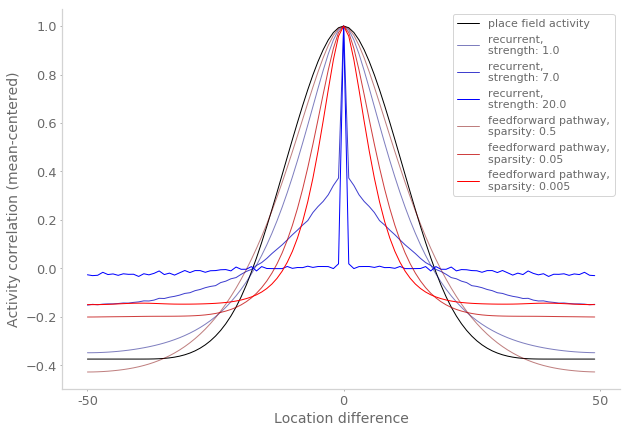

In [9]:
figsize=(10,7)
plt.figure(figsize=figsize)
corr_func = pairwise_cos_sim_centered

plt.plot(cross_corr_from_pairwise(corr_func(np.clip(place_inputs, 0, np.inf))), color="black", label="place field activity")

for i, r in enumerate(rec_strength_options):
    acts = all_acts[i]
    plt.plot(cross_corr_from_pairwise(corr_func(acts)), 
            color=[0, 0, 2.0*(float(i)+2)/8, 2.0*(float(i)+2)/8], label="recurrent,\nstrength: "+str(r))
for i, s in enumerate(sparsity_options):
    plt.plot(cross_corr_from_pairwise(corr_func(ff_barcodes[i])),
            color=[2.0*(float(i)+2)/8, 0, 0, 2.0*(float(i)+2)/8], label="feedforward pathway,\nsparsity: "+str(s))
    
plt.legend(fontsize=11)
plt.xticks(np.arange(0, num_states+1, 50), np.arange(0, num_states+1, 50)-num_states//2)
plt.xlabel("Location difference")
plt.ylabel("Activity correlation (mean-centered)")

Text(0, 0.5, 'Activity correlation (noiseless)')

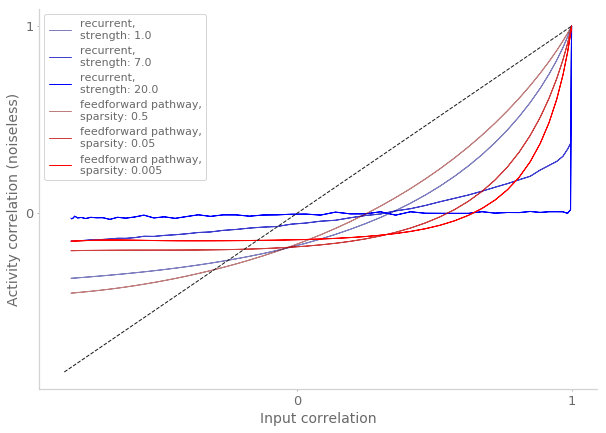

In [11]:
figsize=(10,7)
plt.figure(figsize=figsize)
corr_func = pairwise_cos_sim_centered

xvals = cross_corr_from_pairwise(corr_func(place_inputs))
                                 
for i, r in enumerate(rec_strength_options):
    acts = all_acts[i]
    plt.plot(xvals, cross_corr_from_pairwise(corr_func(acts)), 
            color=[0, 0, 2.0*(float(i)+2)/8, 2.0*(float(i)+2)/8], label="recurrent,\nstrength: "+str(r))
for i, s in enumerate(sparsity_options):
    plt.plot(xvals, cross_corr_from_pairwise(corr_func(ff_barcodes[i])),
            color=[2.0*(float(i)+2)/8, 0, 0, 2.0*(float(i)+2)/8], label="feedforward pathway,\nsparsity: "+str(s))
    
plt.legend(fontsize=11)
#plt.xticks(np.arange(0, num_states+1, 50), np.arange(0, num_states+1, 50)-num_states//2)
plt.xticks([-1, 0, 1])
plt.yticks([-1, 0, 1])
plt.plot([-0.85, 1], [-0.85, 1], linestyle="--", color="k")
plt.xlabel("Input correlation")
plt.ylabel("Activity correlation (noiseless)")